In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0


In [3]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

import lightkurve as lk

In [4]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [5]:
# Guesses from search
periods = np.array([17.47114])
t0s = np.array([1661.0628])
depths = 1e3 * np.array([0.0328])**2
durations = np.array([3.0]) / 24.0
letters = "bcd"

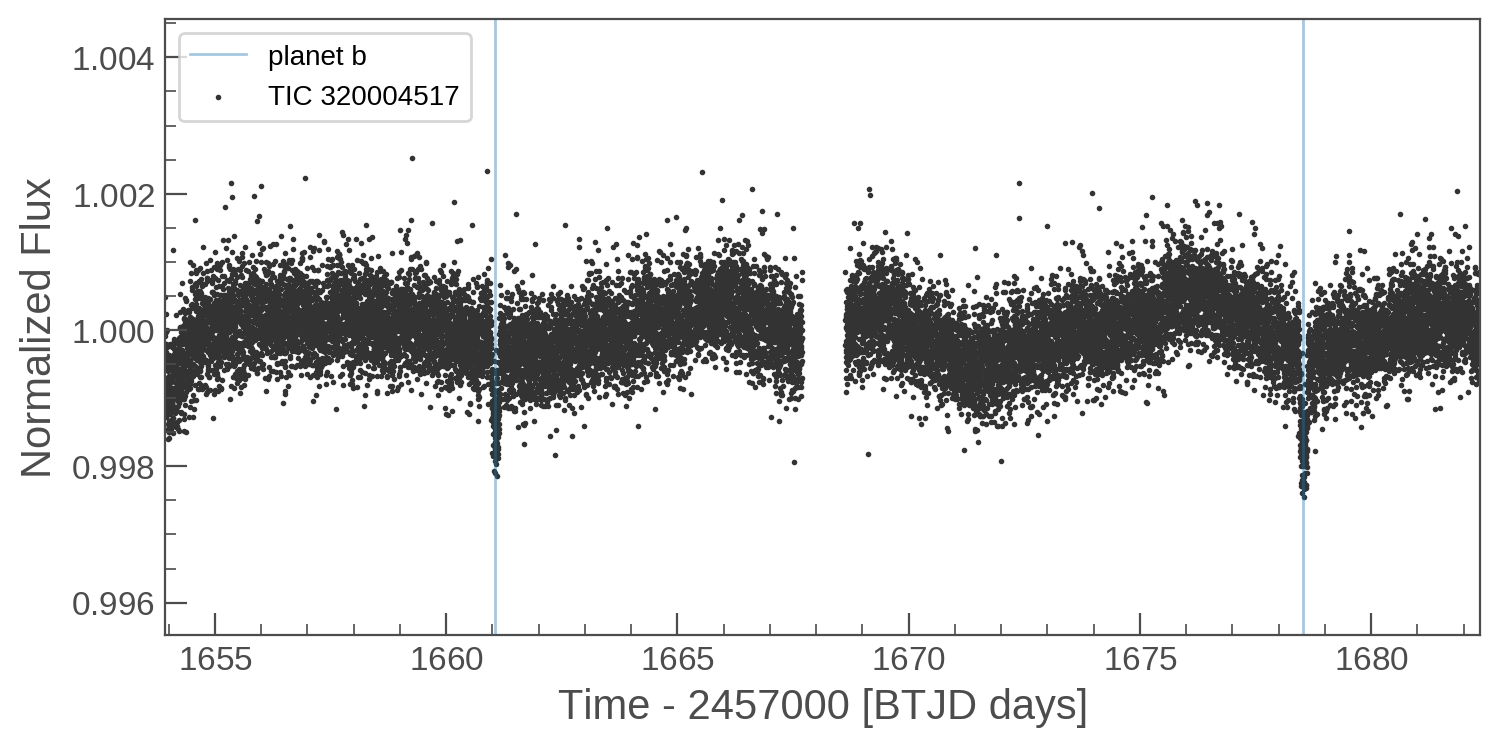

In [6]:
# Download the target pixel files
sr = lk.search_lightcurvefile('TIC {0}'.format(tic_id))
lc_collection = sr.download_all(quality_bitmask="hardest")
if lc_collection is None or not len(lc_collection):
    raise ValueError("we can't find any light curves")

# Extract the exposure time associated with the light curve
hdr = lc_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Loop over light curves and stitch
lc = lc_collection[0].PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
for lc0 in lc_collection[1:]:
    lc = lc.append(lc0.PDCSAP_FLUX.remove_nans().normalize().remove_outliers())
    
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# This helper function shows the transit times
def indicate_transits(ax=None):
    if ax is None:
        ax = plt.gca()
    for i in range(len(periods)):
        mn = np.floor((x.min() - t0s[i]) / periods[i])
        mx = np.ceil((x.max() - t0s[i]) / periods[i])
        label = "planet {0}".format(letters[i])
        for ind in np.arange(mn, mx + 1):
            ax.axvline(t0s[i] + ind * periods[i], color="C{0}".format(i),
                       linewidth=1, alpha=0.4, label=label)
            label = None

# Plot the data
lc.scatter()
indicate_transits()
plt.legend(fontsize=10)
plt.xlim(x.min(), x.max());

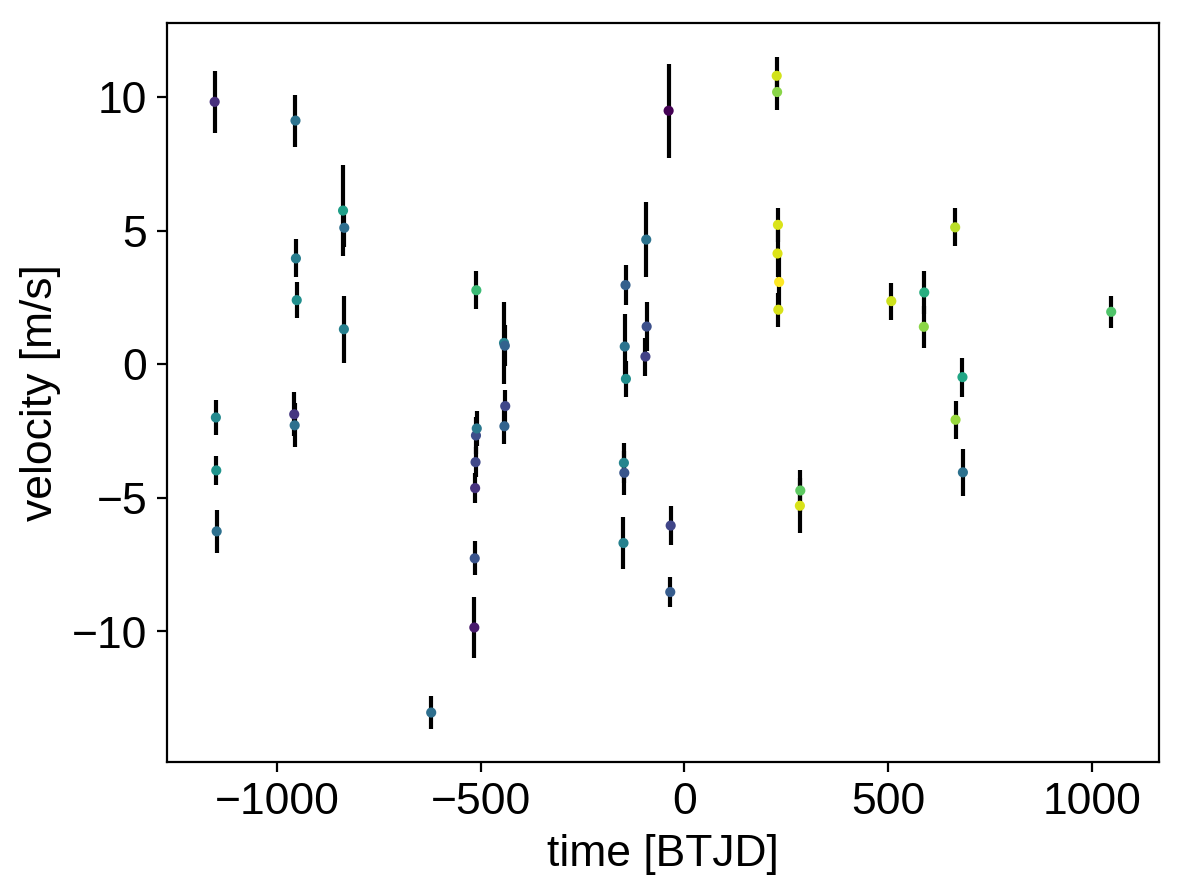

In [9]:
BTJD_ref = 2457000

df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)

t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv, y_rv, c=df.bis, s=7)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

In [8]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = msini.to(u.M_earth)
print(msini)

[5.28529097] earthMass


In [10]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        mean_flux = pm.Normal("mean_flux", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        log_period = pm.Normal("log_period", mu=np.log(periods[0]), sd=10.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0)
        
        log_ror = pm.Uniform("log_ror", lower=np.log(0.01), upper=np.log(0.1),
                             testval=0.5*np.log(1e-3*depths[0]))
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        b_hat = xo.distributions.UnitUniform("b_hat")
        b = pm.Deterministic("b", b_hat * (1 + ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value[0]), sd=5)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.UnitUniform("ecc", testval=0.01)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        
        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(3))[::-1], shape=3)
        trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(3))[::-1], shape=3)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        model.light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) + mean_flux

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()))
        pm.Potential("transit_obs", model.gp.log_likelihood(y[mask] - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv, 3)
        A_bis = np.vander(bis_rv, 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend) + tt.dot(A_bis, trend_bis))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", vrad + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv, 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv, trend, trend_bis])
        map_soln = xo.optimize(start=map_soln, vars=[log_ror, b_hat])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [11]:
model, map_soln = build_model()

optimizing logp for variables: ['logs2']
message: Optimization terminated successfully.
logp: -12207.441169248003 -> -11523.33466673243
optimizing logp for variables: ['trend_bis', 'trend', 'logs_rv']
message: Desired error not necessarily achieved due to precision loss.
logp: -11523.33466673243 -> -11049.812928719326
optimizing logp for variables: ['b_hat_logodds__', 'log_ror_interval__']
message: Optimization terminated successfully.
logp: -11049.812928719322 -> -11020.412008490708
optimizing logp for variables: ['t0_interval__', 'log_period']
message: Desired error not necessarily achieved due to precision loss.
logp: -11020.41200849071 -> -11020.14816218267
optimizing logp for variables: ['log_m_pl_lowerbound__']
message: Optimization terminated successfully.
logp: -11020.14816218267 -> -11017.624840657418
optimizing logp for variables: ['logpower', 'logs2']
message: Optimization terminated successfully.
logp: -11017.624840657418 -> -10968.89817712463
optimizing logp for variables:

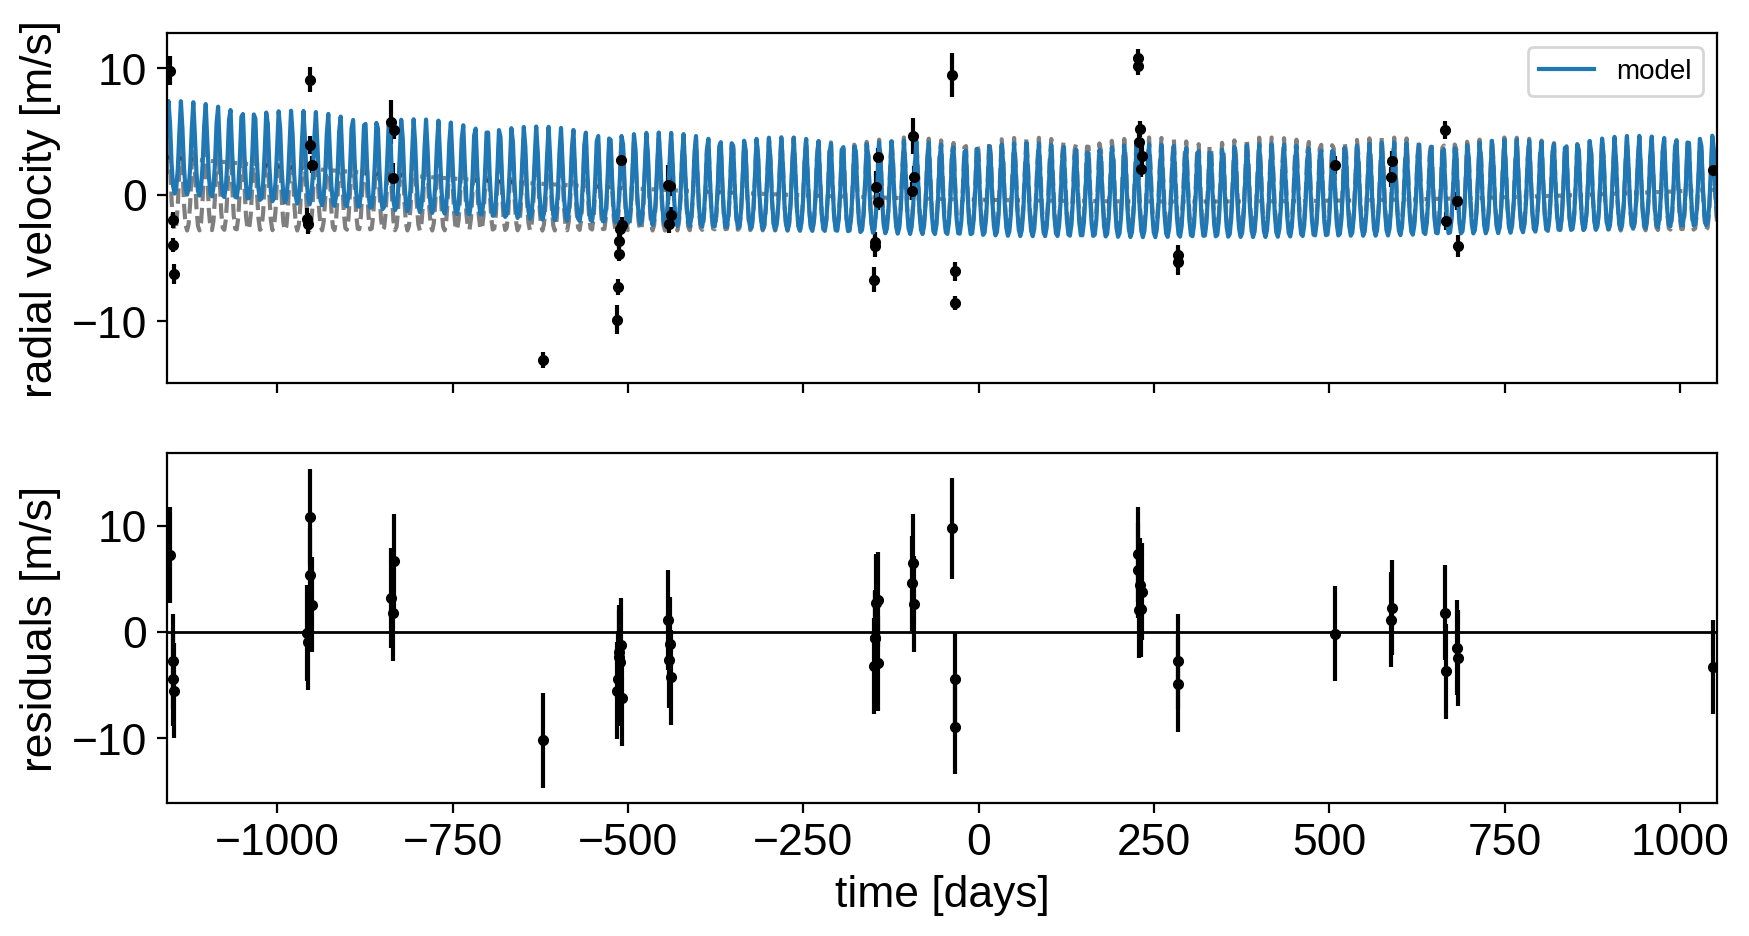

In [12]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")

    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")

plot_rv_curve(map_soln)

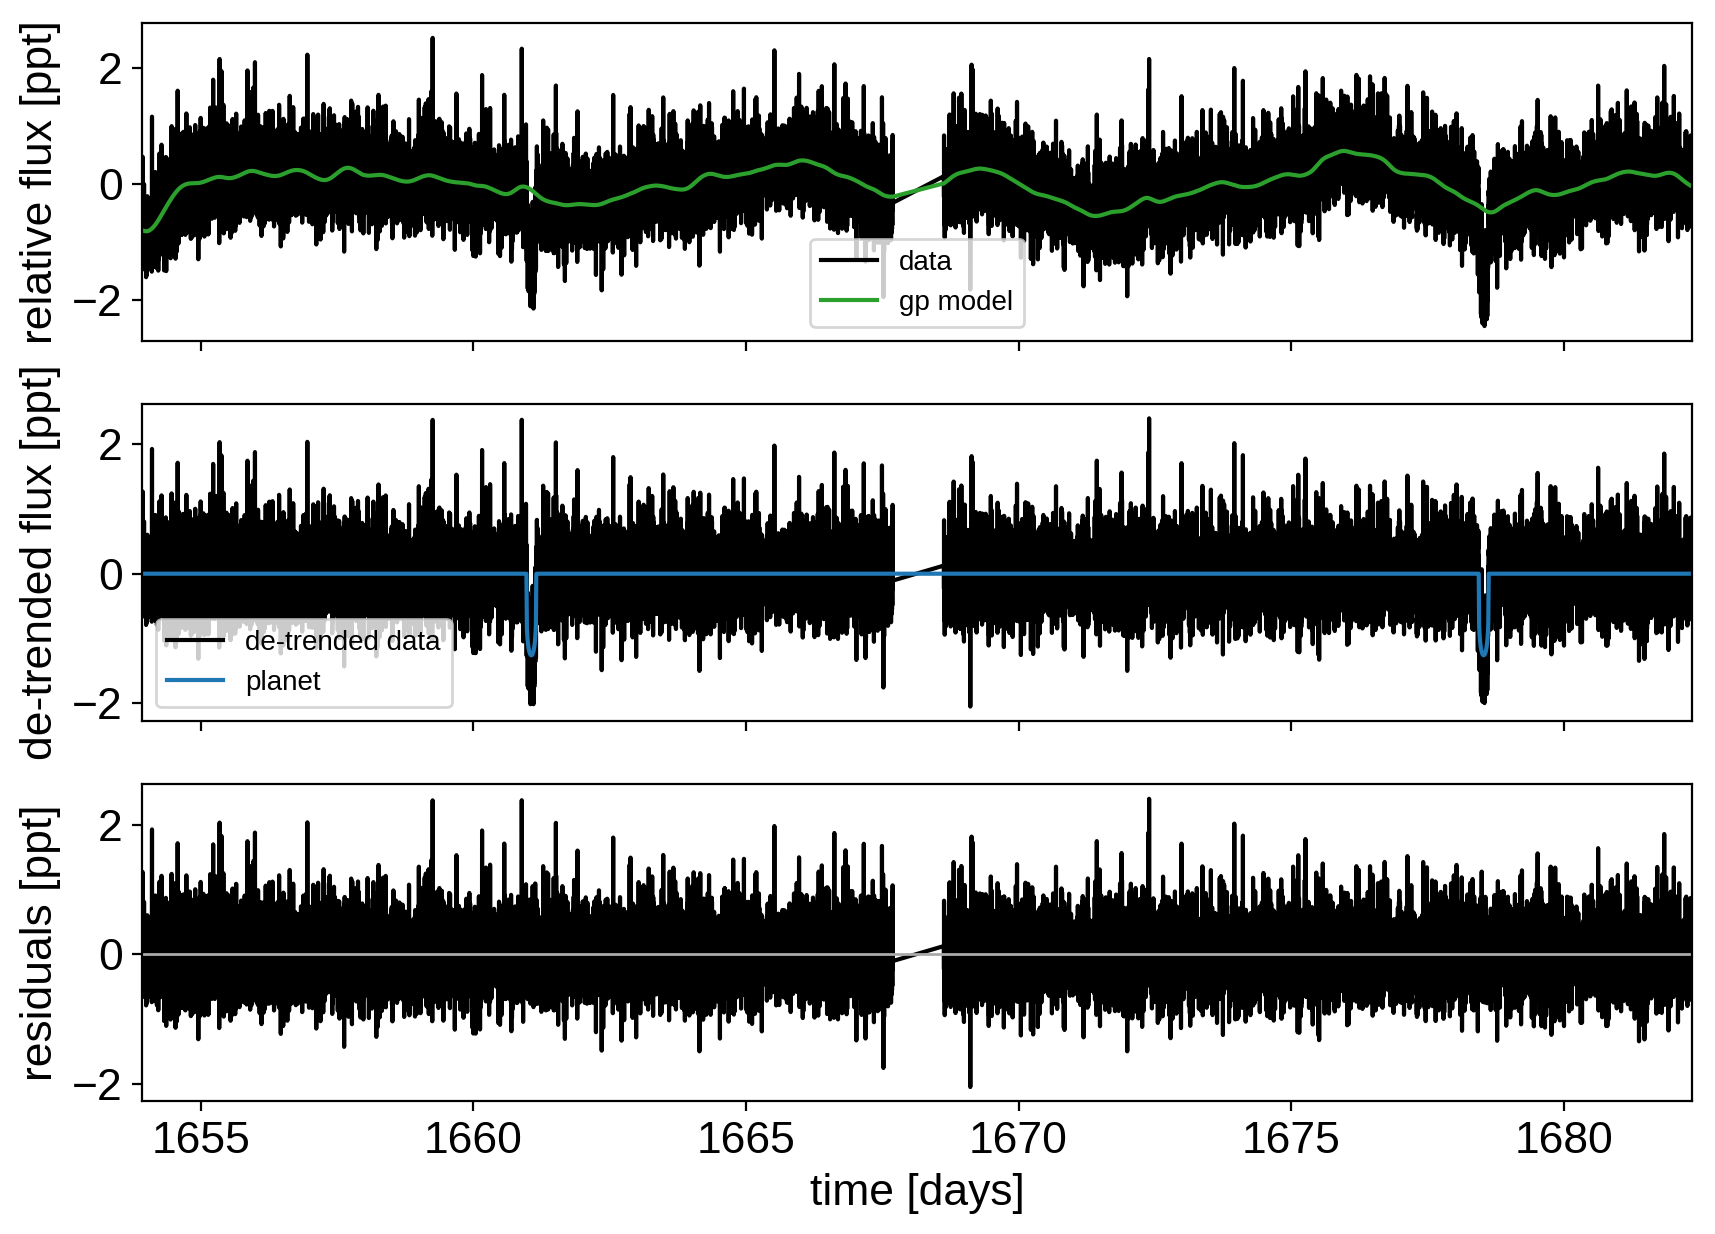

In [13]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
    
    with model:
        gp_mod, lc_mod = xo.eval_in_model([
            model.gp_pred + model.mean_flux, model.light_curve - model.mean_flux], soln)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    ax.plot(x[mask], lc_mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + lc_mod
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig

plot_light_curve(model, map_soln);

Text(0, 0.5, 'rv residuals')

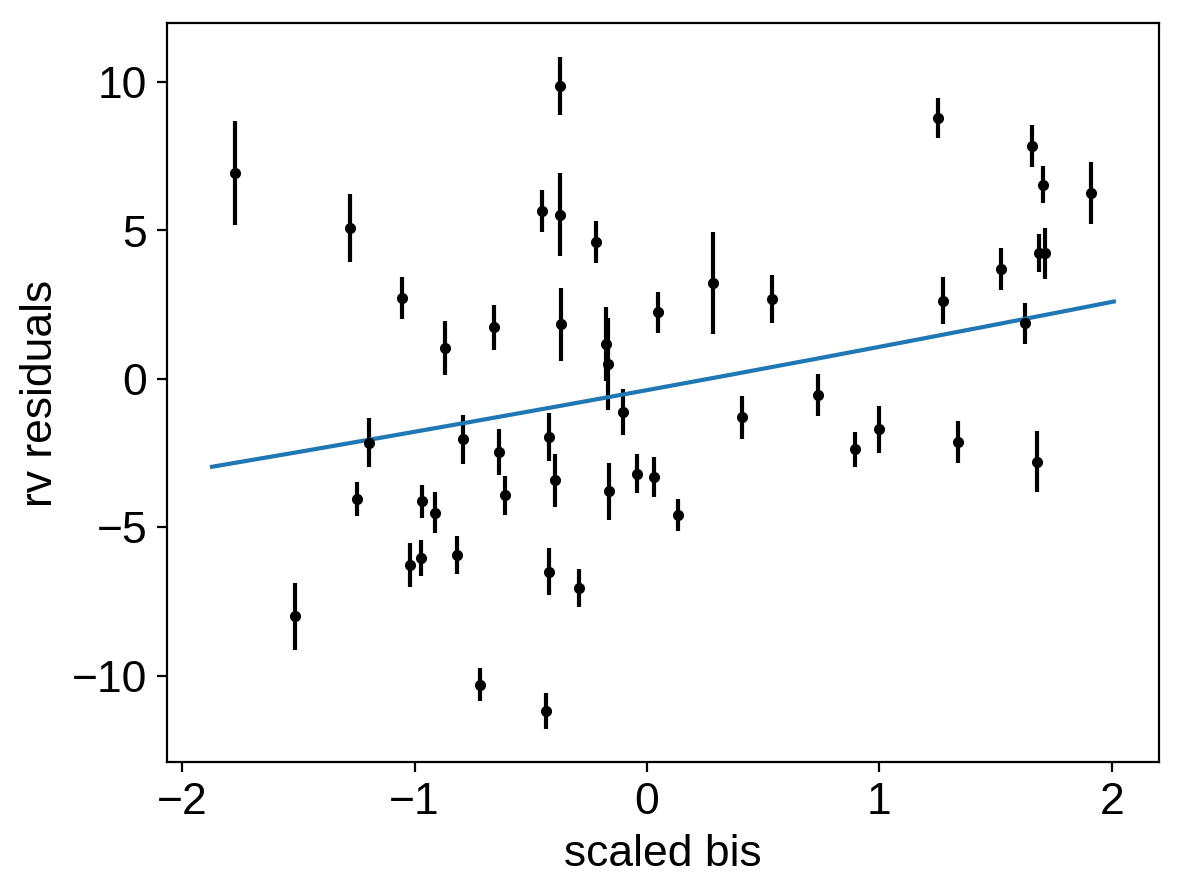

In [21]:
bkg_bis0 = np.dot(np.vander(bis_rv, 3), map_soln["trend_bis"])

bis_test = np.linspace(bis_rv.min() - 0.1, bis_rv.max() + 0.1, 5000)
bkg_bis = np.dot(np.vander(bis_test, 3), map_soln["trend_bis"])

plt.errorbar(bis_rv, y_rv - map_soln["rv_model"] + bkg_bis0, yerr=yerr_rv, fmt=".k")
plt.plot(bis_test, bkg_bis)
plt.xlabel("scaled bis")
plt.ylabel("rv residuals")

In [22]:
np.random.seed(123)
with model:
    trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend_bis, trend, logs_rv, logpower, logw0, logs2, omega, ecc, log_m_pl, b_hat, log_ror, t0, log_period, u_star, mean_flux, mr_star]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [27:30<00:00,  2.19draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [23]:
pm.summary(trace, varnames=[k for k in trace.varnames if not k.endswith("__") and not k in ("vrad", "vrad_pred", "bkg", "rv_model", "rv_model_pred", "bkg_pred")])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean_flux,-0.018698,0.064283,1.555377e-03,-0.149300,0.112381,1791.890616,0.999581
log_period,2.860557,0.000088,1.992447e-06,2.860389,2.860730,2147.027369,0.999771
logs2,-1.751241,0.010360,2.068250e-04,-1.771403,-1.731876,2071.658744,1.000669
logw0,0.738543,0.152093,3.848727e-03,0.445954,1.026896,1819.613311,0.999933
logpower,0.026233,0.320651,6.502886e-03,-0.579761,0.654984,2289.697582,0.999520
logs_rv,1.552502,0.107985,2.703225e-03,1.338822,1.759324,1675.049865,0.999926
trend__0,0.000002,0.000002,6.212737e-08,-0.000002,0.000006,1495.850170,0.999510
trend__1,-0.000310,0.001753,4.955422e-05,-0.003639,0.003174,1367.589325,0.999532
trend__2,-0.726023,7.062416,1.594676e-01,-13.892835,13.371963,2192.153892,0.999566
trend_bis__0,0.024571,0.103736,2.041251e-03,-0.173398,0.225660,3025.157756,0.999514


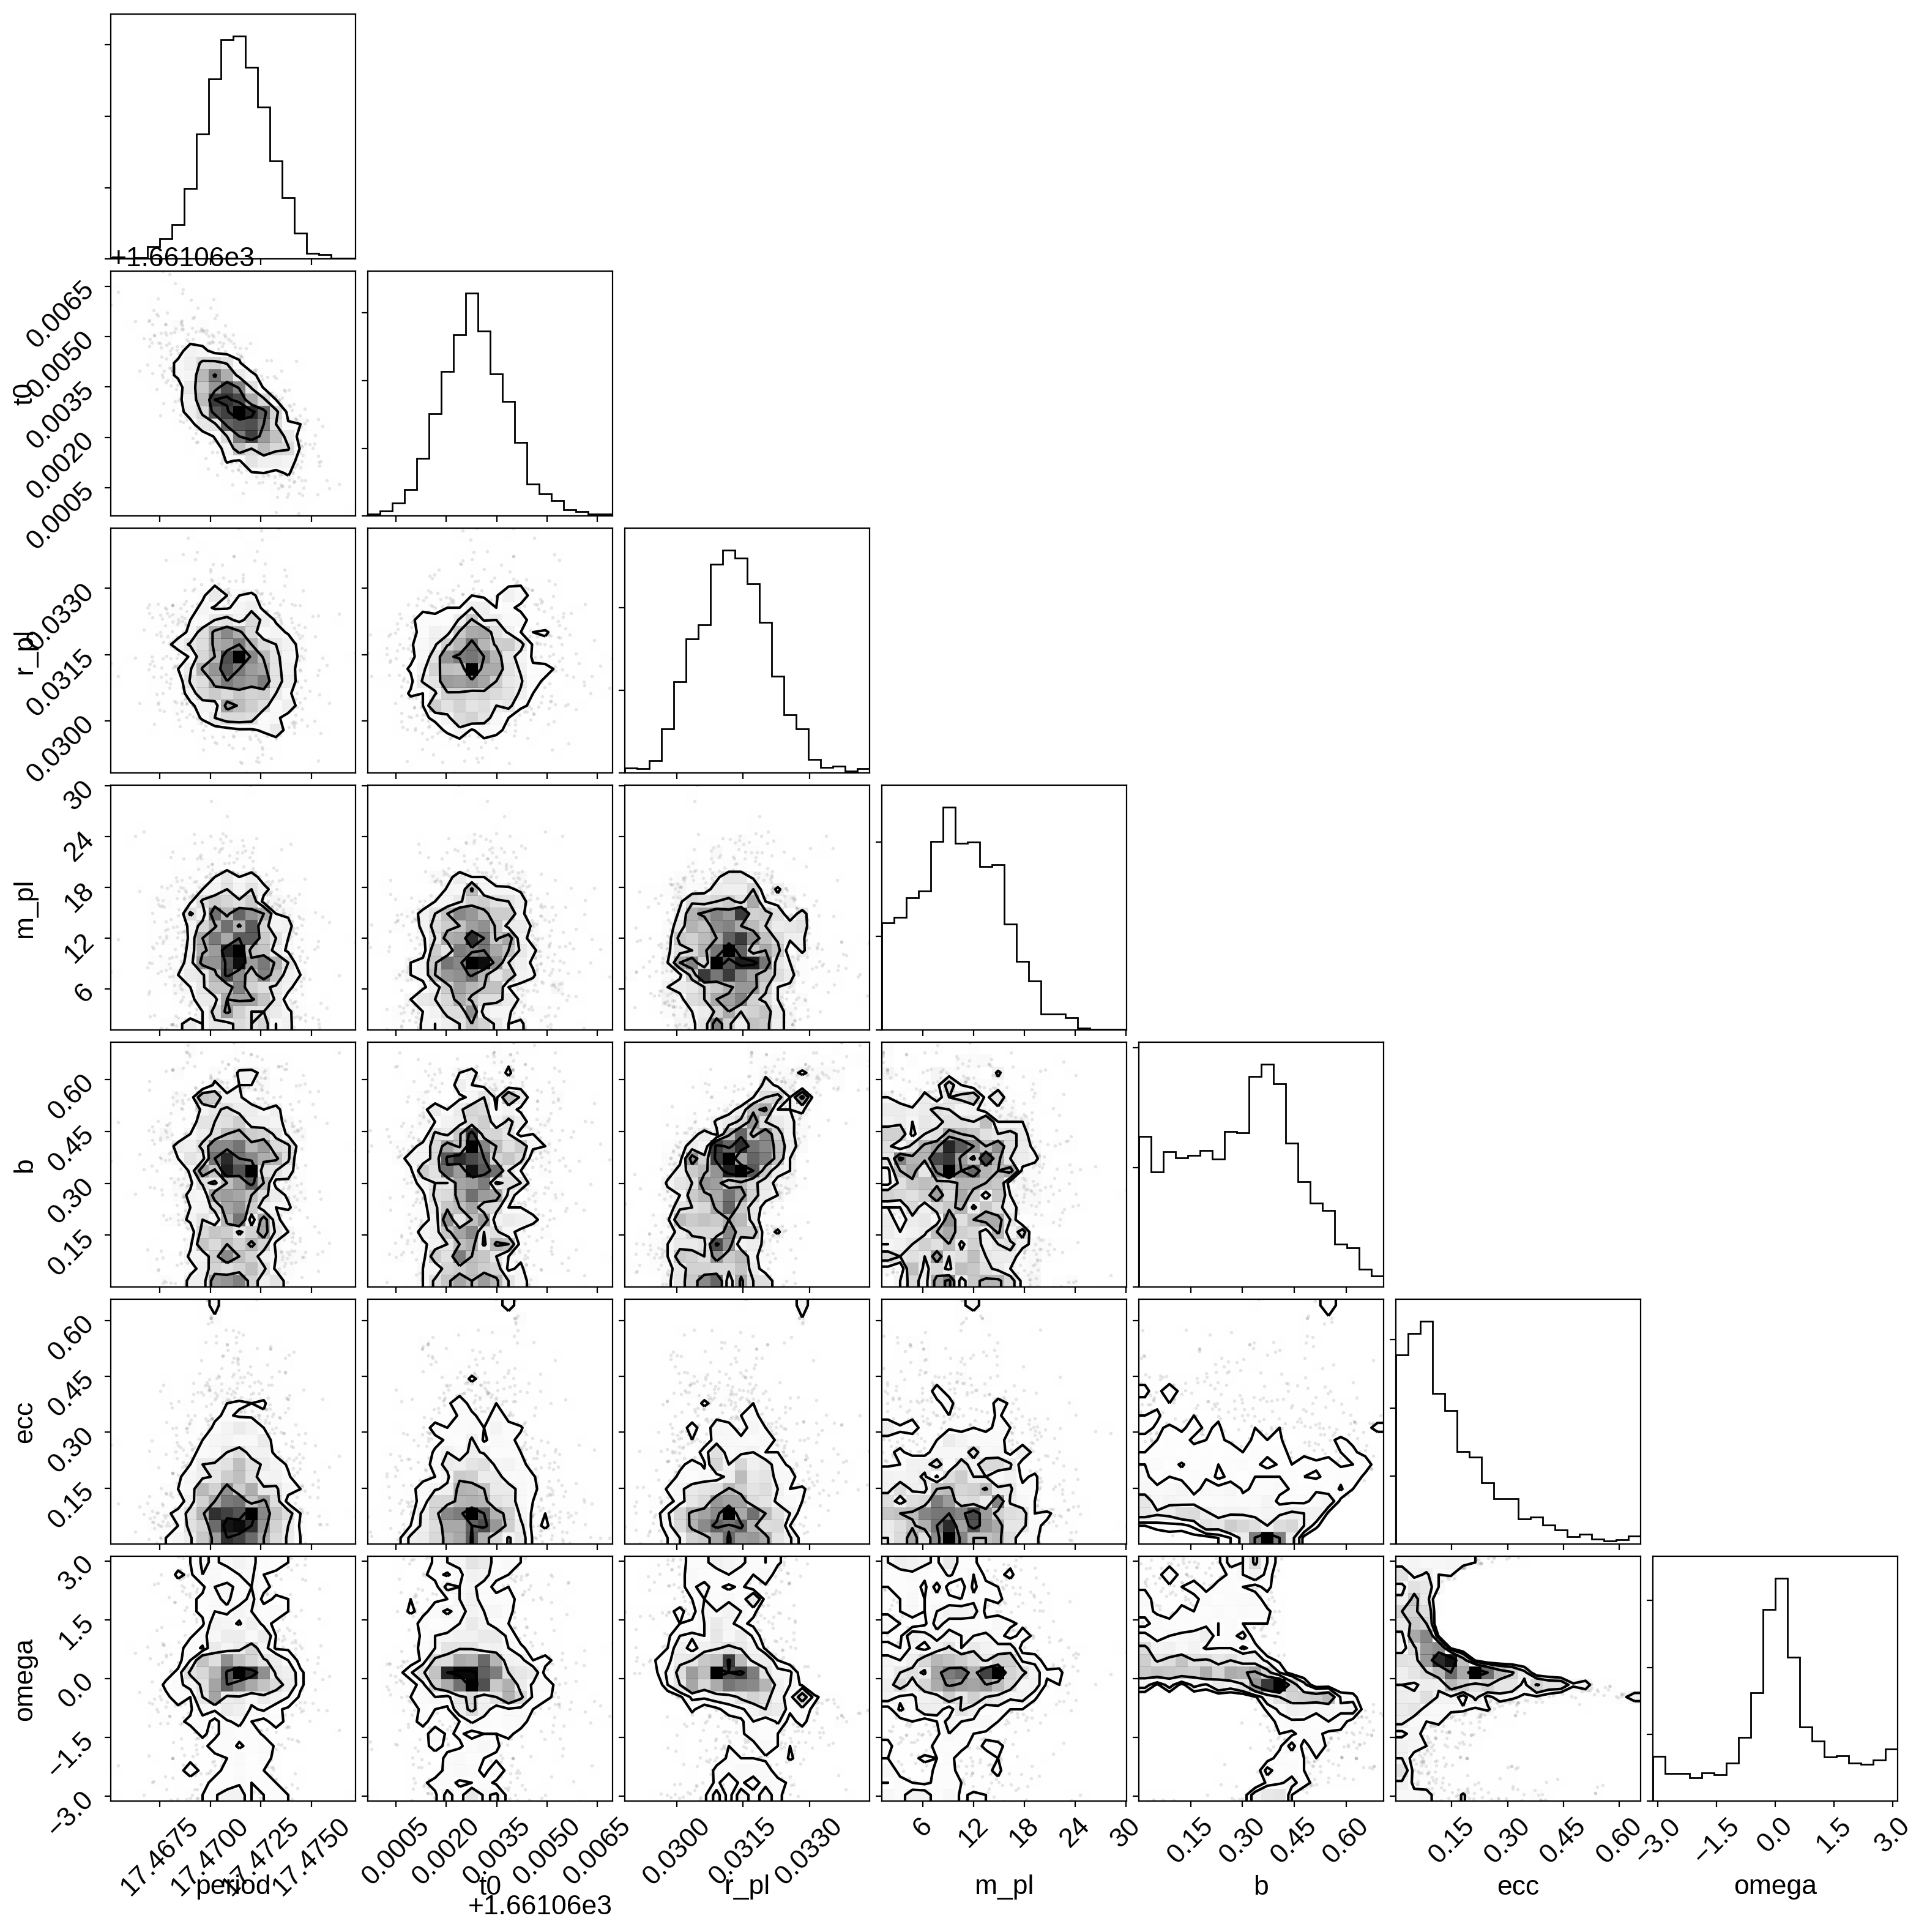

In [25]:
varnames = ["period", "t0", "r_pl", "m_pl", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

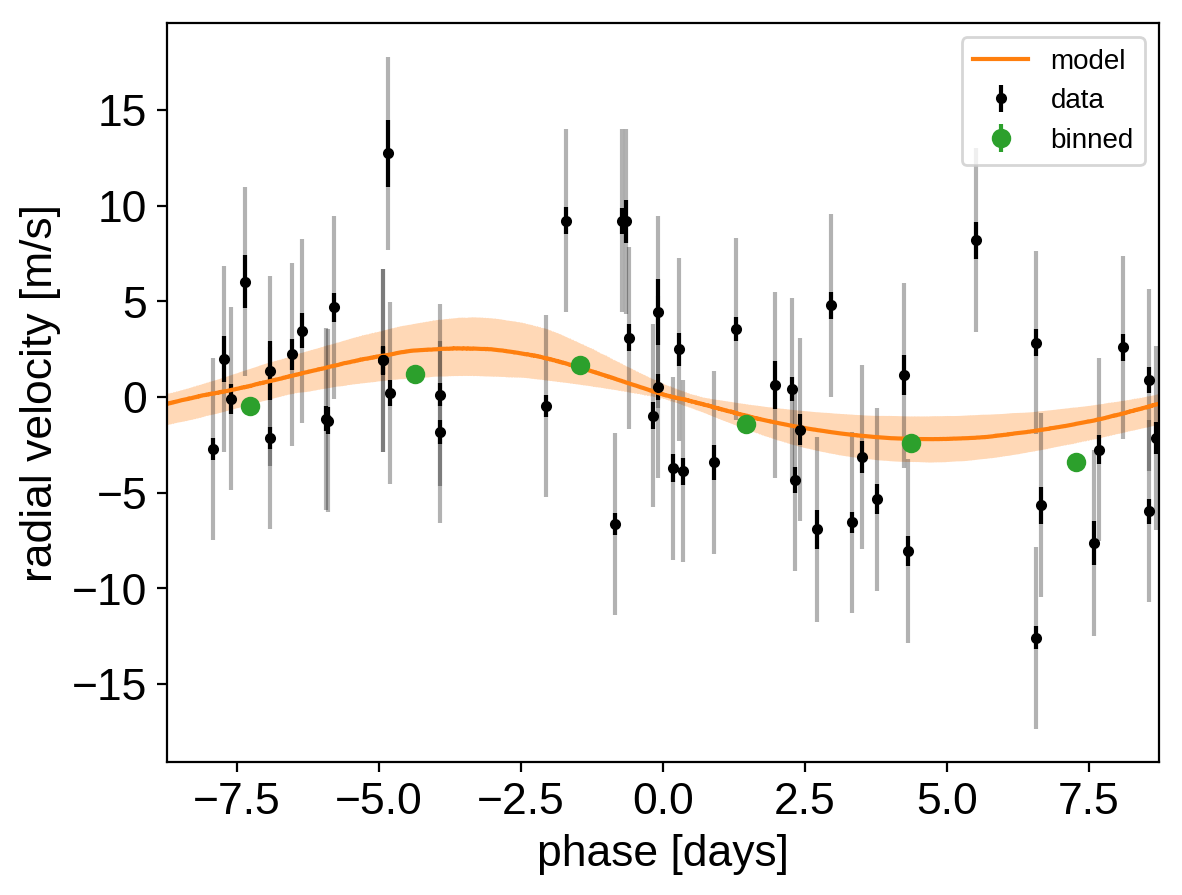

In [45]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2 = np.exp(2*np.median(trace["logs_rv"]))

bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_rv - bkg, yerr=np.sqrt(yerr_rv**2 + jit2), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]");